# CS 510 Project
This Python script was written by Cassidy Buhler cb3452@drexel.edu  
Fish data was obtained by Shraman Kadapa sk3496@drexel.edu using COMSOL and Matlab


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import math
import os
import random as python_random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import metrics

## Importing Data

In [3]:
## setting seeds to ensure producibility of results 
os.environ['PYTHONHASHSEED']='0'
np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)

In [4]:
path = "/content/gdrive/My Drive/CS510/project/"  #cassie's path to the file -- probably not be the same on your machine
df = pd.read_excel(path+'data/fishdatav2.xlsx',index_col = 0)#read in data
df = df[['Frequency(hz)','Distance b/w fins','Lateral(N)','Thrust(N)','Phase difference(degrees)']] #reording the columns so target features are the last 2
df['Phase difference(degrees)'] =np.deg2rad(df['Phase difference(degrees)']) #convert to radians before scaling - not sure why but it performs better than if kept in degrees  
df.rename(columns = {'Frequency(hz)':'Frequency','Thrust(N)':'Thrust', 'Distance b/w fins':'Distance','Lateral(N)': 'Lateral Force','Phase difference(degrees)':'Phase Difference'},inplace = True) #renaming columns to shorten 

## Visualizing Dataset 

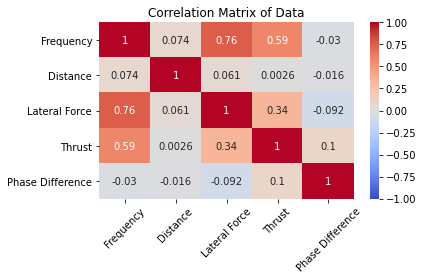

In [5]:
sns.heatmap(df.corr(),annot=True,vmin=-1, vmax=1, center= 0, cmap= 'coolwarm') #visualizing data 
plt.xticks(rotation=45) 
plt.title("Correlation Matrix of Data")
plt.tight_layout()
plt.savefig(path+'figures/corr_mat.png')
plt.show()

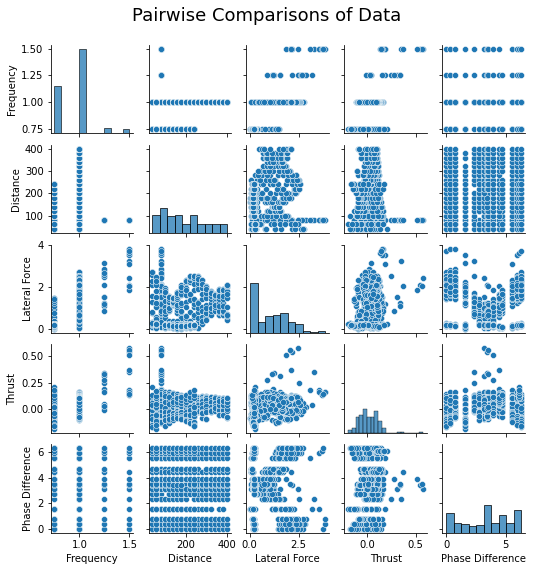

In [6]:
f = sns.pairplot(df,height = 1.5)
f.fig.suptitle("Pairwise Comparisons of Data",fontsize = 18, y = 1.05) 
f.tight_layout()
f.savefig(path+'figures/pairplot.png')
plt.show()

## Prepping data for training

In [7]:
def splitData(df): #80/10/10 data split 
  Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=0,shuffle = True) # split data into test and train 
  Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size =0.11, random_state=0,shuffle = True) #split training again to get the validation set 
  scaler = MinMaxScaler(feature_range=(-1,1)) 
  scaler.fit(Xtrain)   #standardizing features based on training data
  Xtrain = scaler.transform(Xtrain)  
  Xval = scaler.transform(Xval) 
  Xtest = scaler.transform(Xtest) 
  scaler_target =  MinMaxScaler(feature_range=(-1,1)) 
  scaler_target.fit(ytrain) 
  ytrain = scaler_target.transform(ytrain) 
  yval = scaler_target.transform(yval)
  ytest = scaler_target.transform(ytest)
  return Xtrain, ytrain, Xval, yval, Xtest, ytest, scaler_target


In [8]:
xcols = ['Frequency','Distance','Lateral Force'] #features 
ycols = ['Thrust','Phase Difference'] #target data 
X = df[xcols] #feature matrix
y = df[ycols] #target matrix 
Xtrain, ytrain, Xval, yval, Xtest, ytest, scaler_target = splitData(df) #splitting data into 3 groups: train, validation, and test

## Neural Networks

In [9]:
def plotProgress(history,num): #plotting the training progress on validation and training data 
  plt.plot(history.history['loss']) # plotting MSE (loss) 
  plt.plot(history.history['val_loss'])
  plt.title('NN'+str(num)+': Loss (MSE)')
  plt.ylabel('MSE')
  plt.xlabel('Epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.tight_layout()
  plt.savefig(path+'figures/MSE'+str(num)+'.png')
  plt.show()  
  return 
  

def getResults(model,Xtest,ytest,scaler_target, num):
  results = model.evaluate(Xtest,ytest)
  ypred = model.predict(Xtest, verbose=0) #predict output on test data
  ytest, ypred = unscaleData(ytest,ypred,scaler_target)
  graphPredictions(ypred,ytest,num)
  print("Model MSE:%.4f" % keras.losses.mean_squared_error(ytest.flatten(), ypred.flatten()))
  print("Thrust MSE:%.4f" % keras.losses.mean_squared_error(ytest[:,0], ypred[:,0])) 
  print("Phase Difference MSE:%.4f" % keras.losses.mean_squared_error(ytest[:,1], ypred[:,1]))
  return 

def unscaleData(ytest,ypred,scaler_target): #we reverting back to original scaling for target data to get a better idea of model accuracy 
  ytest = scaler_target.inverse_transform(ytest)
  ypred = scaler_target.inverse_transform(ypred)
  return ytest, ypred

def graphPredictions(ypred,ytest,num): #graphing predictions from network 
  a = plt.axes(aspect='equal')
  lims = [min(min(ypred[:,0]),min(ytest[:,0])), max(max(ypred[:,0]),max(ytest[:,0]))]
  plt.xlim(lims)
  plt.ylim(lims)
  plt.plot(lims, lims,'k--',label = 'perfect fit')
  m, b = np.polyfit(ytest[:,0], ypred[:,0], 1)
  xvals = np.sort(np.append(ytest[:,0], max(max(ypred[:,0]),max(ytest[:,0]))))
  plt.plot(xvals, m*xvals + b,'k-',label = 'actual fit')
  plt.plot(ytest[:,0],ypred[:,0],'b.',label = 'thrust')
  plt.xlabel('True Thrust (N)')
  plt.ylabel('Predicted Thrust (N)')
  plt.title('NN' +str(num) + ': Thrust Prediction Accuracy')
  plt.legend()
  plt.tight_layout()
  plt.savefig(path+'figures/predictionThrust'+str(num)+'.png')
  plt.show()

  a = plt.axes(aspect='equal')
  lims = [min(min(ypred[:,1]),min(ytest[:,1])), max(max(ypred[:,1]),max(ytest[:,1]))]
  plt.xlim(lims)
  plt.ylim(lims)
  plt.plot(lims, lims,'k--',label = 'perfect fit')
  m, b = np.polyfit(ytest[:,1], ypred[:,1], 1)
  xvals = np.sort(ytest[:,1])
  plt.plot(xvals, m*xvals + b,'k-',label = 'actual fit')
  plt.plot(ytest[:,1],ypred[:,1],'r.',label = 'phase difference')
  plt.legend()
  plt.xlabel('True Phase Difference (radians)')
  plt.ylabel('Predicted Phase Difference (radians)')
  plt.title('NN' +str(num) + ': Phase Difference Prediction Accuracy')
  plt.tight_layout()
  plt.savefig(path+'figures/predictionPhaseDiff'+str(num)+'.png')
  plt.show()
  return 



## Neural Network #1

Epoch 1/500
23/23 - 1s - loss: 0.3599 - mae: 0.5236 - val_loss: 0.3867 - val_mae: 0.5252
Epoch 2/500
23/23 - 0s - loss: 0.3256 - mae: 0.4884 - val_loss: 0.3573 - val_mae: 0.4935
Epoch 3/500
23/23 - 0s - loss: 0.3005 - mae: 0.4599 - val_loss: 0.3363 - val_mae: 0.4713
Epoch 4/500
23/23 - 0s - loss: 0.2830 - mae: 0.4379 - val_loss: 0.3222 - val_mae: 0.4553
Epoch 5/500
23/23 - 0s - loss: 0.2707 - mae: 0.4223 - val_loss: 0.3127 - val_mae: 0.4446
Epoch 6/500
23/23 - 0s - loss: 0.2619 - mae: 0.4104 - val_loss: 0.3053 - val_mae: 0.4357
Epoch 7/500
23/23 - 0s - loss: 0.2559 - mae: 0.4007 - val_loss: 0.2993 - val_mae: 0.4285
Epoch 8/500
23/23 - 0s - loss: 0.2510 - mae: 0.3927 - val_loss: 0.2952 - val_mae: 0.4223
Epoch 9/500
23/23 - 0s - loss: 0.2471 - mae: 0.3866 - val_loss: 0.2915 - val_mae: 0.4173
Epoch 10/500
23/23 - 0s - loss: 0.2443 - mae: 0.3816 - val_loss: 0.2885 - val_mae: 0.4127
Epoch 11/500
23/23 - 0s - loss: 0.2419 - mae: 0.3780 - val_loss: 0.2849 - val_mae: 0.4093
Epoch 12/500
23/23 

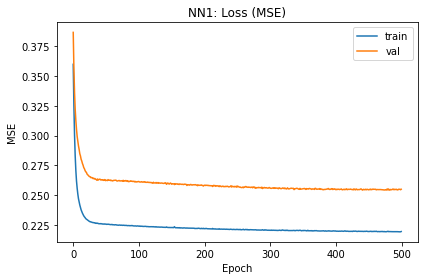

2/2 [==============================] - 0s 9ms/step - loss: 0.1665 - mae: 0.2787


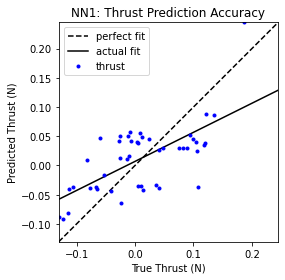

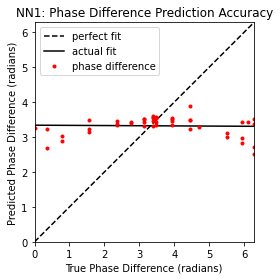

Model MSE:1.5285
Thrust MSE:0.0033
Phase Difference MSE:3.0537


In [10]:
def NN1(Xtrain,Xval,ytrain,yval,path,num):
  n_input = Xtrain.shape[1] # this will be 3 since we have 3 input features 
  n_output = ytrain.shape[1] # this will be 2 since we have 2 output features
  model = keras.Sequential()
  model.add(keras.layers.Input(shape = (n_input,),name = 'Input_Layer'))
  model.add(keras.layers.Dense(20, activation="elu",name = 'Layer_1'))
  model.add(keras.layers.Dense(20, activation="elu",name = 'Layer_2'))
  model.add(keras.layers.Dense(10, activation="elu",name = 'Layer_3'))
  model.add(keras.layers.Dense(n_output, activation = 'linear', name = 'Output_Layer'))
  metrics = ['mae'] 
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.mean_squared_error, metrics=metrics)
  history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=500, verbose=2,batch_size=16) #get model training results 

  model.summary()
  plotProgress(history,num) #plot progress 
  keras.utils.plot_model(model, path+'figures/NN'+str(num)+'.png', show_shapes=True) #save model
  return model 

model1 = NN1(Xtrain,Xval,ytrain,yval,path,1) #calling model 
getResults(model1,Xtest,ytest,scaler_target,1) #getting prediction metrics

## Neural Network #2

Epoch 1/500
23/23 - 1s - loss: 0.7526 - mae: 0.6936 - val_loss: 0.4188 - val_mae: 0.5138
Epoch 2/500
23/23 - 0s - loss: 0.6990 - mae: 0.6746 - val_loss: 0.3953 - val_mae: 0.4926
Epoch 3/500
23/23 - 0s - loss: 0.5854 - mae: 0.6170 - val_loss: 0.3787 - val_mae: 0.4782
Epoch 4/500
23/23 - 0s - loss: 0.5862 - mae: 0.6334 - val_loss: 0.3648 - val_mae: 0.4631
Epoch 5/500
23/23 - 0s - loss: 0.5781 - mae: 0.6153 - val_loss: 0.3494 - val_mae: 0.4460
Epoch 6/500
23/23 - 0s - loss: 0.4943 - mae: 0.5723 - val_loss: 0.3387 - val_mae: 0.4362
Epoch 7/500
23/23 - 0s - loss: 0.5031 - mae: 0.5806 - val_loss: 0.3301 - val_mae: 0.4294
Epoch 8/500
23/23 - 0s - loss: 0.4597 - mae: 0.5413 - val_loss: 0.3233 - val_mae: 0.4246
Epoch 9/500
23/23 - 0s - loss: 0.4041 - mae: 0.5136 - val_loss: 0.3168 - val_mae: 0.4187
Epoch 10/500
23/23 - 0s - loss: 0.3957 - mae: 0.5090 - val_loss: 0.3129 - val_mae: 0.4156
Epoch 11/500
23/23 - 0s - loss: 0.4283 - mae: 0.5215 - val_loss: 0.3083 - val_mae: 0.4136
Epoch 12/500
23/23 

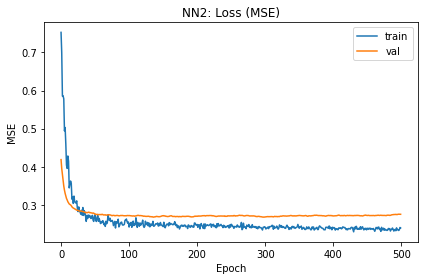

2/2 [==============================] - 0s 7ms/step - loss: 0.1599 - mae: 0.2833


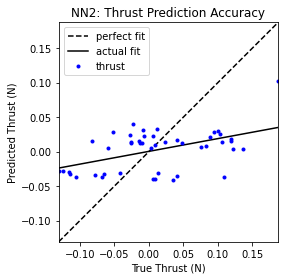

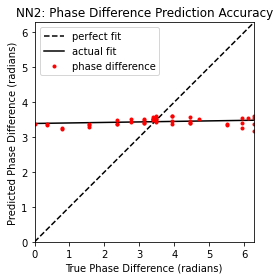

Model MSE:1.4167
Thrust MSE:0.0047
Phase Difference MSE:2.8288


In [11]:
def NN2(Xtrain,Xval,ytrain,yval,path,num): 
  n_input = Xtrain.shape[1] # this will be 3 since we have 3 input features 
  n_output = ytrain.shape[1] # this will be 2 since we have 2 output features
  model = keras.Sequential()
  model.add(keras.Input(shape = (n_input,),name = 'Input_Layer'))
  model.add(keras.layers.Dense(50, activation="elu",name = 'Layer_1'))
  model.add(keras.layers.AlphaDropout(0.25, name = 'Dropout'))
  model.add(keras.layers.Dense(40, activation="elu",name = 'Layer_2'))
  model.add(keras.layers.Dense(30, activation="elu",name = 'Layer_3'))
  model.add(keras.layers.Dense(n_output, activation = 'linear', name = 'Output_Layer'))
  metrics = ['mae']  # want to look at mean absolute error + MSE while training data 
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.mean_squared_error, metrics=metrics)
  history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=500, verbose=2,batch_size = 16) #get model training results 
  model.summary()
  plotProgress(history,num) #plot progress
  keras.utils.plot_model(model, path+'figures/NN'+str(num)+'.png', show_shapes=True) #save model
  return model

model2 = NN2(Xtrain,Xval,ytrain,yval,path,2) #calling model 
getResults(model2,Xtest,ytest,scaler_target,2)

Epoch 1/500
23/23 - 1s - loss: 0.3305 - mae: 0.4934 - val_loss: 0.3775 - val_mae: 0.5103
Epoch 2/500
23/23 - 0s - loss: 0.3214 - mae: 0.4837 - val_loss: 0.3693 - val_mae: 0.5020
Epoch 3/500
23/23 - 0s - loss: 0.3130 - mae: 0.4744 - val_loss: 0.3617 - val_mae: 0.4942
Epoch 4/500
23/23 - 0s - loss: 0.3055 - mae: 0.4655 - val_loss: 0.3547 - val_mae: 0.4866
Epoch 5/500
23/23 - 0s - loss: 0.2985 - mae: 0.4572 - val_loss: 0.3487 - val_mae: 0.4796
Epoch 6/500
23/23 - 0s - loss: 0.2924 - mae: 0.4498 - val_loss: 0.3429 - val_mae: 0.4734
Epoch 7/500
23/23 - 0s - loss: 0.2869 - mae: 0.4430 - val_loss: 0.3376 - val_mae: 0.4681
Epoch 8/500
23/23 - 0s - loss: 0.2817 - mae: 0.4365 - val_loss: 0.3332 - val_mae: 0.4634
Epoch 9/500
23/23 - 0s - loss: 0.2772 - mae: 0.4307 - val_loss: 0.3290 - val_mae: 0.4590
Epoch 10/500
23/23 - 0s - loss: 0.2732 - mae: 0.4254 - val_loss: 0.3253 - val_mae: 0.4550
Epoch 11/500
23/23 - 0s - loss: 0.2695 - mae: 0.4207 - val_loss: 0.3216 - val_mae: 0.4515
Epoch 12/500
23/23 

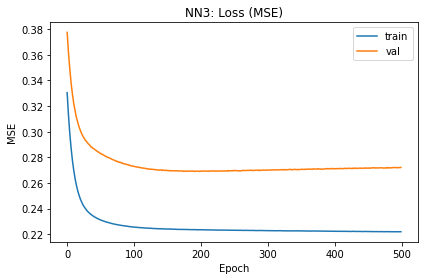

2/2 [==============================] - 0s 8ms/step - loss: 0.1647 - mae: 0.2811


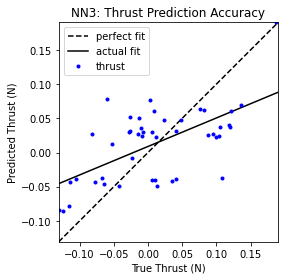

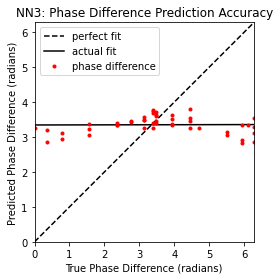

Model MSE:1.4952
Thrust MSE:0.0038
Phase Difference MSE:2.9866


In [12]:
def NN3(Xtrain,Xval,ytrain,yval,path,num): 
  n_input = Xtrain.shape[1] # this will be 3 since we have 3 input features 
  n_output = ytrain.shape[1] # this will be 2 since we have 2 output features
  model = keras.Sequential()
  model.add(keras.Input(shape = (n_input,),name = 'Input_Layer'))
  model.add(keras.layers.Dense(40, activation="elu",name = 'Layer_1'))
  model.add(keras.layers.Dense(20, activation="elu",name = 'Layer_2'))
  model.add(keras.layers.Dense(10, activation="elu",name = 'Layer_3'))
  model.add(keras.layers.Dense(n_output, activation = 'linear', name = 'Output_Layer'))
  metrics = ['mae']  # want to look at mean absolute error + MSE while training data 
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.000025), loss=keras.losses.mean_squared_error, metrics=metrics)
  history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=500, verbose=2,batch_size = 16) #get model training results 
  model.summary()

  plotProgress(history,num) #plot progress
  keras.utils.plot_model(model, path+'figures/NN'+str(num)+'.png', show_shapes=True) #save model
  return model

model3 = NN3(Xtrain,Xval,ytrain,yval,path,3) #calling model 
getResults(model3,Xtest,ytest,scaler_target,3)